# External Sorting Memory Analysis

This notebook analyzes memory usage patterns for external sorting with separate run generation and merge phases.

## Key Formulas:
- **Run Generation Memory**: `run_size × threads`
- **Merge Memory**: `(D / run_size) × threads × page_size`
- **Constraints**:
  - Max run size (run gen): `run_size ≤ M / T`
  - Min run size (merge): `run_size ≥ D × P × T / M`

In [33]:
# Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib import cm

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Constants
P_KB = 64  # Page size in KB
P_MB = P_KB / 1024  # Page size in MB (0.0625)
MB = 1024 * 1024  # Bytes to MB conversion
GB = 1024 * 1024 * 1024  # Bytes to GB conversion

## 1. Memory Usage Matrices

Visualize how memory usage varies with thread count and run size for both phases.

In [34]:
# Define thread counts and run sizes
thread_counts = [1, 2, 4, 8, 16, 32, 64]
run_sizes_mb = [8, 16, 32, 64, 128, 256, 512, 1024]  # 8MB to 1GB
run_size_labels = ['8MB', '16MB', '32MB', '64MB', '128MB', '256MB', '512MB', '1GB']

# Create memory usage matrices
memory_matrix = np.zeros((len(run_sizes_mb), len(thread_counts)))
for i, run_size in enumerate(run_sizes_mb):
    for j, threads in enumerate(thread_counts):
        memory_matrix[i, j] = run_size * threads

# Flip for display (small sizes at bottom)
memory_matrix_flipped = np.flipud(memory_matrix)
run_size_labels_flipped = list(reversed(run_size_labels))

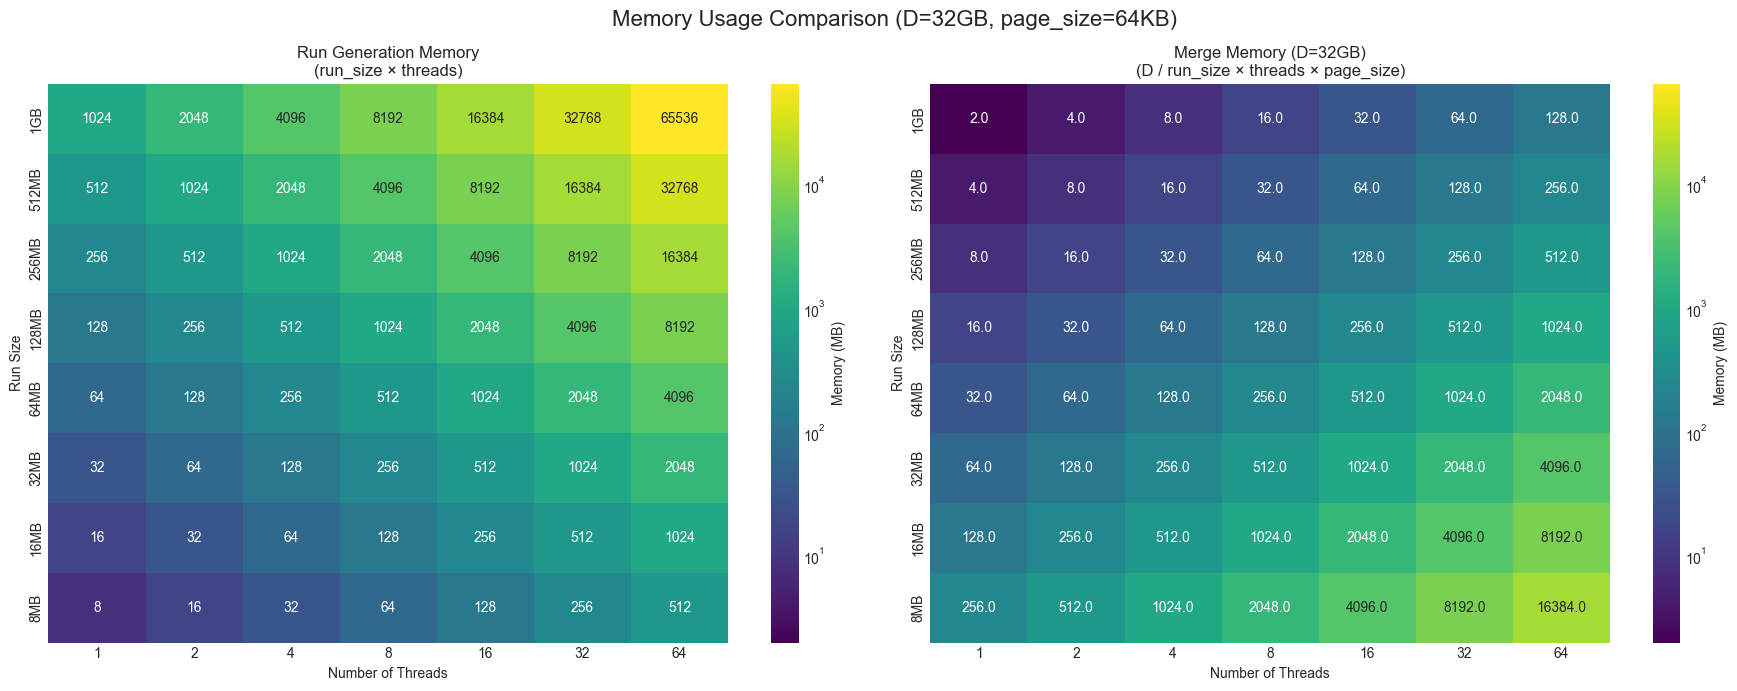


Optimal configuration for D=32GB:
  Run size: 32MB, Threads: 1
  Memory: Run Gen=32MB, Merge=64.0MB, Total=64.0MB


In [35]:
# Interactive memory comparison with adjustable dataset size
def plot_memory_comparison(D_GB=32, machine_memory_mb=None):
    """
    Plot memory usage comparison for run generation and merge phases.
    
    Args:
        D_GB: Dataset size in GB
        machine_memory_mb: Optional memory constraint to highlight
    """
    D_MB = D_GB * 1024
    
    # Calculate merge memory matrix
    merge_memory_matrix = np.zeros((len(run_sizes_mb), len(thread_counts)))
    for i, run_size in enumerate(run_sizes_mb):
        for j, threads in enumerate(thread_counts):
            merge_memory_matrix[i, j] = (D_MB / run_size) * threads * P_MB
    
    # Flip matrices
    merge_memory_flipped = np.flipud(merge_memory_matrix)
    
    # Find global min/max for consistent color scale
    vmin = min(memory_matrix_flipped.min(), merge_memory_flipped.min())
    vmax = max(memory_matrix_flipped.max(), merge_memory_flipped.max())
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Use log normalization
    norm = colors.LogNorm(vmin=max(vmin, 0.1), vmax=vmax)
    
    # Plot heatmaps
    sns.heatmap(memory_matrix_flipped, annot=True, fmt='.0f', cmap='viridis',
                norm=norm, xticklabels=thread_counts, yticklabels=run_size_labels_flipped,
                cbar_kws={'label': 'Memory (MB)'}, ax=ax1)
    ax1.set_xlabel('Number of Threads')
    ax1.set_ylabel('Run Size')
    ax1.set_title('Run Generation Memory\n(run_size × threads)')
    
    sns.heatmap(merge_memory_flipped, annot=True, fmt='.1f', cmap='viridis',
                norm=norm, xticklabels=thread_counts, yticklabels=run_size_labels_flipped,
                cbar_kws={'label': 'Memory (MB)'}, ax=ax2)
    ax2.set_xlabel('Number of Threads')
    ax2.set_ylabel('Run Size')
    ax2.set_title(f'Merge Memory (D={D_GB}GB)\n(D / run_size × threads × page_size)')
    
    # Add memory constraint lines if specified
    if machine_memory_mb:
        for ax, matrix in [(ax1, memory_matrix), (ax2, merge_memory_matrix)]:
            for i, run_size in enumerate(reversed(run_sizes_mb)):
                max_threads = machine_memory_mb / run_size
                if matrix is merge_memory_matrix:
                    max_threads = machine_memory_mb / ((D_MB / run_size) * P_MB)
                
                # Find boundary position
                for j, t in enumerate(thread_counts):
                    if t > max_threads:
                        if j > 0:
                            x_pos = j - 0.5 + (max_threads - thread_counts[j-1]) / (t - thread_counts[j-1])
                            ax.plot([0, x_pos], [i, i], 'r-', linewidth=3)
                        break
                else:
                    ax.plot([0, len(thread_counts)], [i, i], 'r-', linewidth=3)
    
    plt.suptitle(f'Memory Usage Comparison (D={D_GB}GB, page_size=64KB)', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print optimal configuration
    min_memory = float('inf')
    optimal_config = None
    
    for run_size, label in zip(run_sizes_mb, run_size_labels):
        for threads in thread_counts:
            run_gen_mem = run_size * threads
            merge_mem = (D_MB / run_size) * threads * P_MB
            total_mem = max(run_gen_mem, merge_mem)
            
            if total_mem < min_memory:
                min_memory = total_mem
                optimal_config = (label, threads, run_gen_mem, merge_mem)
    
    if optimal_config:
        label, threads, run_gen, merge = optimal_config
        print(f"\nOptimal configuration for D={D_GB}GB:")
        print(f"  Run size: {label}, Threads: {threads}")
        print(f"  Memory: Run Gen={run_gen:.0f}MB, Merge={merge:.1f}MB, Total={min_memory:.1f}MB")

# Example usage
plot_memory_comparison(D_GB=32)

## 2. Run Size Constraints Visualization

Shows the feasible region between minimum and maximum run size constraints.

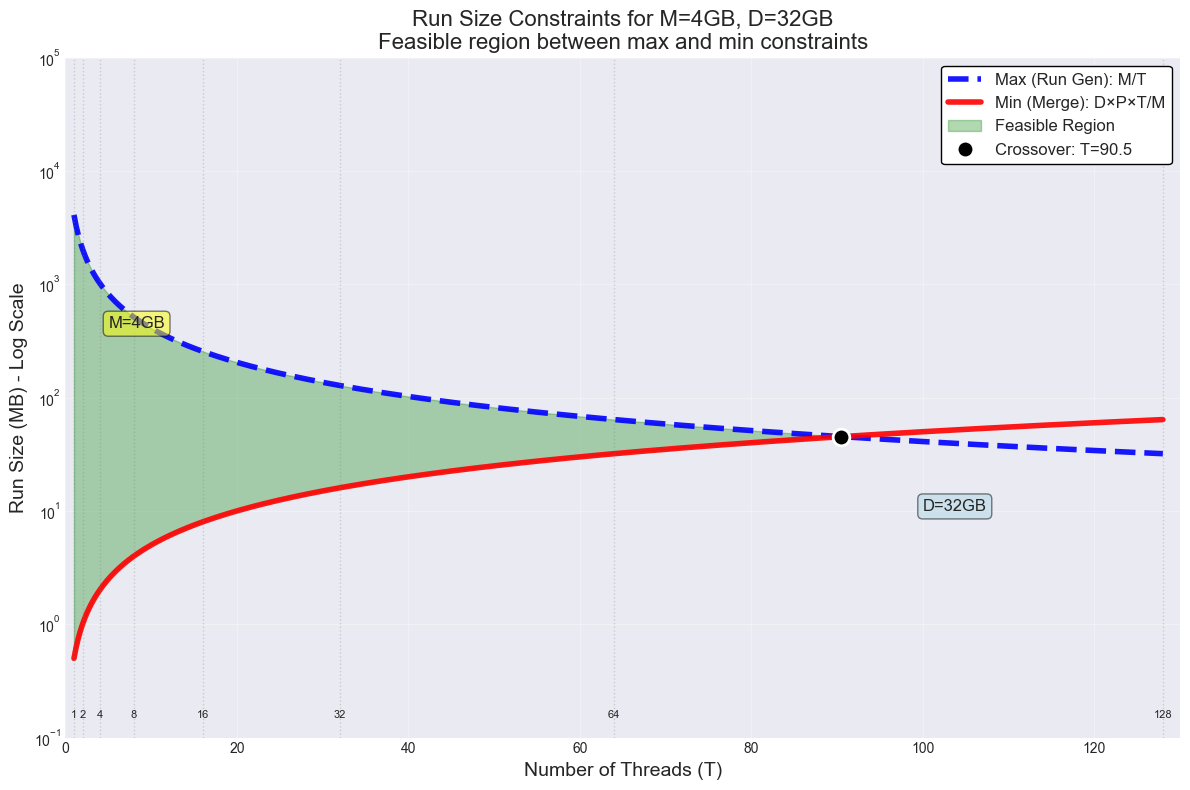


Analysis for M=4GB, D=32GB:
Maximum feasible threads: 90.5
Optimal run size at crossover: 45MB
Practical recommendation: Use 32 threads or fewer

Feasible run size ranges:
   1 threads:    0.5 -   4096 MB
   2 threads:    1.0 -   2048 MB
   4 threads:    2.0 -   1024 MB
   8 threads:    4.0 -    512 MB
  16 threads:    8.0 -    256 MB
  32 threads:   16.0 -    128 MB


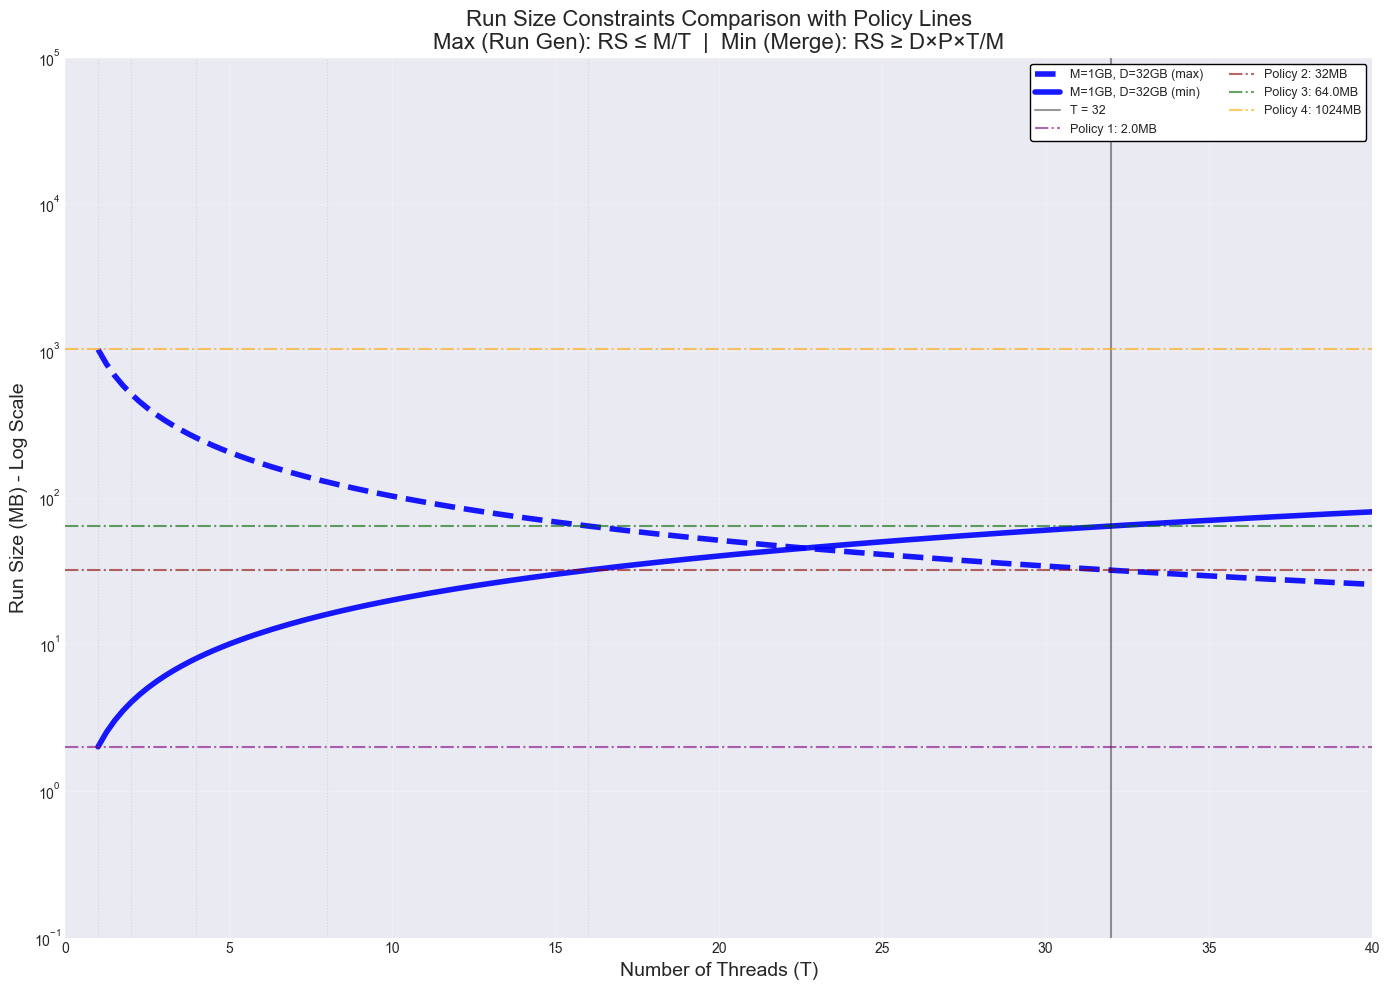


Crossover Analysis (where constraints meet):
Config                    Max Threads     Crossover RS (MB)
------------------------------------------------------------
M=1GB, D=32GB             22.6            1448           

Policy Lines (based on M=1GB, D=32GB):
Policy 1: Min constraint at T=1     = 2.0 MB
Policy 2: Max constraint at T=32    = 32 MB
Policy 3: Min constraint at T=32    = 64.0 MB
Policy 4: Max constraint at T=1     = 1024 MB


In [39]:
def plot_constraints(M_GB=4, D_GB=32, scale='semilogy'):
    """
    Plot run size constraints for a specific memory and dataset size.
    
    Args:
        M_GB: Total memory in GB
        D_GB: Dataset size in GB
        scale: 'semilogy', 'loglog', or 'linear'
    """
    plt.figure(figsize=(12, 8))
    
    # Thread values
    T_values = np.linspace(1, 128, 500)
    
    # Convert to MB
    M_MB = M_GB * 1024
    D_MB = D_GB * 1024
    
    # Calculate constraints
    max_run_size = M_MB / T_values  # Run gen constraint
    min_run_size = (D_MB * P_MB * T_values) / M_MB  # Merge constraint
    
    # Plot function based on scale
    plot_func = {'semilogy': plt.semilogy, 'loglog': plt.loglog, 'linear': plt.plot}[scale]
    
    # Plot constraints with thick lines
    plot_func(T_values, max_run_size, '--', color='blue', 
              linewidth=4, label=f"Max (Run Gen): M/T", alpha=0.9)
    plot_func(T_values, min_run_size, '-', color='red', 
              linewidth=4, label=f"Min (Merge): D×P×T/M", alpha=0.9)
    
    # Fill feasible region
    feasible_mask = min_run_size <= max_run_size
    if np.any(feasible_mask):
        plt.fill_between(T_values[feasible_mask], 
                        min_run_size[feasible_mask], 
                        max_run_size[feasible_mask],
                        alpha=0.3, color='green', label='Feasible Region')
    
    # Mark crossover point
    T_crossover = M_MB / np.sqrt(D_MB * P_MB)
    RS_crossover = M_MB / T_crossover
    if 1 <= T_crossover <= 128:
        plt.plot(T_crossover, RS_crossover, 'o', color='black', 
                markersize=12, markeredgewidth=2, markeredgecolor='white',
                label=f'Crossover: T={T_crossover:.1f}')
    
    # Formatting
    plt.xlabel('Number of Threads (T)', fontsize=14)
    plt.ylabel('Run Size (MB)' + (' - Log Scale' if 'log' in scale else ''), fontsize=14)
    plt.title(f'Run Size Constraints for M={M_GB}GB, D={D_GB}GB\n' + 
              'Feasible region between max and min constraints', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 130)
    
    if scale == 'semilogy':
        plt.ylim(0.1, 100000)
    elif scale == 'linear':
        plt.ylim(0, max(M_MB, 5000))
    
    # Mark common thread counts with thin lines
    for t in [1, 2, 4, 8, 16, 32, 64, 128]:
        plt.axvline(x=t, color='gray', linestyle=':', alpha=0.3, linewidth=1)
        plt.text(t, plt.ylim()[0] * 1.5, f'{t}', ha='center', fontsize=8, rotation=0)
    
    # Add annotations
    if scale == 'semilogy':
        plt.text(5, M_MB/10, f'M={M_GB}GB', fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
        plt.text(100, 10, f'D={D_GB}GB', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.5))
    
    # Legend with white background and box
    plt.legend(loc='best', fontsize=12, frameon=True, fancybox=True, 
               framealpha=1.0, facecolor='white', edgecolor='black')
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print(f"\nAnalysis for M={M_GB}GB, D={D_GB}GB:")
    print("="*50)
    print(f"Maximum feasible threads: {T_crossover:.1f}")
    print(f"Optimal run size at crossover: {RS_crossover:.0f}MB")
    print(f"Practical recommendation: Use {min(int(T_crossover), 32)} threads or fewer")
    
    # Find feasible range for common thread counts
    print(f"\nFeasible run size ranges:")
    for t in [1, 2, 4, 8, 16, 32]:
        if t <= T_crossover:
            max_rs = M_MB / t
            min_rs = (D_MB * P_MB * t) / M_MB
            print(f"  {t:2d} threads: {min_rs:6.1f} - {max_rs:6.0f} MB")
        else:
            print(f"  {t:2d} threads: No feasible run size")


def plot_multiple_constraints(configs, scale='semilogy', policy_thread=32, policy_config_idx=0):
    """
    Plot multiple configurations on the same graph for comparison with policy lines.
    
    Args:
        configs: List of dicts with 'M_GB', 'D_GB', 'color', 'label' keys
        scale: 'semilogy', 'loglog', or 'linear'
        policy_thread: Thread count to use for policies 2 and 3
        policy_config_idx: Index of configuration to use for policy lines
    """
    plt.figure(figsize=(14, 10))
    
    # Thread values
    T_values = np.linspace(1, 128, 500)
    
    # Plot function based on scale
    plot_func = {'semilogy': plt.semilogy, 'loglog': plt.loglog, 'linear': plt.plot}[scale]
    
    # Track policy values
    policy_values = {}
    
    for idx, config in enumerate(configs):
        M_MB = config['M_GB'] * 1024
        D_MB = config['D_GB'] * 1024
        
        # Constraints - make these lines thick
        max_run_size = M_MB / T_values  # Run gen constraint
        min_run_size = (D_MB * P_MB * T_values) / M_MB  # Merge constraint
        
        # Plot with thick lines
        plot_func(T_values, max_run_size, '--', color=config['color'], 
                  linewidth=4, label=f"{config['label']} (max)", alpha=0.9)
        plot_func(T_values, min_run_size, '-', color=config['color'], 
                  linewidth=4, label=f"{config['label']} (min)", alpha=0.9)
        
        # # Fill feasible region
        # feasible_mask = min_run_size <= max_run_size
        # if np.any(feasible_mask):
        #     plt.fill_between(T_values[feasible_mask], 
        #                     min_run_size[feasible_mask], 
        #                     max_run_size[feasible_mask],
        #                     alpha=0.2, color=config['color'])
        
        # # Mark crossover point
        # T_crossover = M_MB / np.sqrt(D_MB * P_MB)
        # RS_crossover = M_MB / T_crossover
        # if 1 <= T_crossover <= 128:
        #     plt.plot(T_crossover, RS_crossover, 'o', color=config['color'], 
        #             markersize=10, markeredgewidth=2, markeredgecolor='black')
        
        # Calculate policy values for the specified config
        if idx == policy_config_idx:
            # Policy 1: min at T=1
            policy_values['policy1'] = (D_MB * P_MB * 1) / M_MB
            # Policy 2: max at policy_thread
            policy_values['policy2'] = M_MB / policy_thread
            # Policy 3: min at policy_thread
            policy_values['policy3'] = (D_MB * P_MB * policy_thread) / M_MB
            # Policy 4: max at T=1
            policy_values['policy4'] = M_MB / 1
    
    # Add vertical line at policy_thread - make it thinner
    plt.axvline(x=policy_thread, color='black', linewidth=1.5, linestyle='-', alpha=0.4,
                label=f'T = {policy_thread}')
    
    # Add policy horizontal lines - make them thinner
    if policy_values:
        # Policy 1
        plt.axhline(y=policy_values['policy1'], color='purple', linewidth=1.5, 
                   linestyle='-.', alpha=0.6, label=f"Policy 1: {policy_values['policy1']:.1f}MB")
        
        # Policy 2
        plt.axhline(y=policy_values['policy2'], color='darkred', linewidth=1.5, 
                   linestyle='-.', alpha=0.6, label=f"Policy 2: {policy_values['policy2']:.0f}MB")
        
        # Policy 3
        plt.axhline(y=policy_values['policy3'], color='darkgreen', linewidth=1.5, 
                   linestyle='-.', alpha=0.6, label=f"Policy 3: {policy_values['policy3']:.1f}MB")
        
        # Policy 4
        plt.axhline(y=policy_values['policy4'], color='orange', linewidth=1.5, 
                   linestyle='-.', alpha=0.6, label=f"Policy 4: {policy_values['policy4']:.0f}MB")
    
    # Formatting
    plt.xlabel('Number of Threads (T)', fontsize=14)
    plt.ylabel('Run Size (MB)' + (' - Log Scale' if 'log' in scale else ''), fontsize=14)
    plt.title('Run Size Constraints Comparison with Policy Lines\n' + 
              'Max (Run Gen): RS ≤ M/T  |  Min (Merge): RS ≥ D×P×T/M', fontsize=16)
    plt.grid(True, alpha=0.2)
    plt.xlim(0, 40)
    
    if scale == 'semilogy':
        plt.ylim(0.1, 100000)
    elif scale == 'linear':
        plt.ylim(0, 5000)
    
    # Mark common thread counts with very thin lines
    for t in [1, 2, 4, 8, 16, 32, 64, 128]:
        if t != policy_thread:
            plt.axvline(x=t, color='gray', linestyle=':', alpha=0.2, linewidth=0.8)
    
    # Legend with white background and box
    plt.legend(loc='best', fontsize=9, ncol=2, frameon=True, fancybox=True,
               framealpha=1.0, facecolor='white', edgecolor='black')
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print("\nCrossover Analysis (where constraints meet):")
    print("="*60)
    print(f"{'Config':<25} {'Max Threads':<15} {'Crossover RS (MB)':<15}")
    print("-"*60)
    
    for config in configs:
        M_MB = config['M_GB'] * 1024
        D_MB = config['D_GB'] * 1024
        T_max = M_MB / np.sqrt(D_MB * P_MB)
        RS_cross = np.sqrt(M_MB * D_MB * P_MB)
        print(f"{config['label']:<25} {T_max:<15.1f} {RS_cross:<15.0f}")
    
    # Print policy definitions
    if policy_values:
        print(f"\nPolicy Lines (based on {configs[policy_config_idx]['label']}):")
        print("="*60)
        print(f"Policy 1: Min constraint at T=1     = {policy_values['policy1']:.1f} MB")
        print(f"Policy 2: Max constraint at T={policy_thread:<2}    = {policy_values['policy2']:.0f} MB")
        print(f"Policy 3: Min constraint at T={policy_thread:<2}    = {policy_values['policy3']:.1f} MB")
        print(f"Policy 4: Max constraint at T=1     = {policy_values['policy4']:.0f} MB")


# Example usage: Single configuration
plot_constraints(M_GB=4, D_GB=32)

# Example usage: Multiple configurations with policy lines
configs = [
    {'M_GB': 1, 'D_GB': 32, 'color': 'blue', 'label': 'M=1GB, D=32GB'},
]
plot_multiple_constraints(configs, policy_thread=32, policy_config_idx=0)